Done by: Yu Bowei, 122118811

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

from seaborn import lmplot, stripplot, scatterplot, heatmap, lineplot, barplot

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_val_score

from sklearn.metrics import accuracy_score, mean_absolute_error
from pandas.plotting import scatter_matrix

from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

<h1>Read in and Check the Data</h1>

In [3]:
# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv("../datasets/dataset_salaries.csv")

# Shuffle the dataset
df = df.sample(frac=1, random_state=2)
df.reset_index(drop=True, inplace=True)

In [4]:
df.shape

(62642, 17)

In [5]:
df.head(10)

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber
0,11/3/2020 10:26:30,Microsoft,60,Data Scientist,181,"Redmond, WA",1,1,ML / AI,104,47,30,Male,mckeiaps hash ghaart gronds wuit zearts tsiott...,11521,819.0,47529
1,8/14/2018 21:08:29,VMware,Senior MTS,Software Engineer,0,"Palo Alto, CA",5,3,Full Stack,0,0,0,NaN,NaN,7351,807.0,1418
2,5/18/2019 0:32:17,Paypal,T25,Software Engineer,213,"San Francisco, CA",7,1,API Development (Back-End),180,19,14,Male,NaN,7419,807.0,8815
3,8/3/2021 20:25:07,Trend Micro,Senior Engineer,Software Engineer,18,"Taipei, TP, Taiwan",2,2,Distributed Systems (Back-End),14,1,3,Male,mcclieusp hyoully preebly gloiands screoch sch...,6744,0.0,81297
4,5/3/2021 15:25:42,Visa,Senior Software Engineer,Software Engineer,179,"Austin, TX",3,0,Full Stack,158,9,12,Female,dyniawn cauny spliur cleals crungs kwoiw thrai...,10965,635.0,68303
5,10/22/2020 13:45:28,Disney Streaming Services,Associate,Software Engineer,61,"New York, NY",5,2,Web Development (Front-End),61,0,0,Female,hypiirth threirty mcmaoft rheoncy truehn,10182,501.0,46130
6,7/31/2021 23:36:52,Xilinx,E8,Software Engineer,452,"San Jose, CA",15,5,ML / AI,237,175,40,NaN,mcmaoll whaians jiats guin screisly youbs scou...,7422,807.0,80836
7,7/29/2021 23:45:20,Weave,P3,Software Engineer,45,"Noida, UP, India",2,0,Distributed Systems (Back-End),45,0,0,Male,synieudly schrauenk mccung smeerg wauepp jeurf...,42631,0.0,80609
8,4/8/2021 9:12:19,Facebook,E4,Software Engineer,202,"Menlo Park, CA",1,1,API Development (Back-End),116,50,36,Female,smiets gluierm splould spaipp gliond thaots sm...,7300,807.0,64734
9,7/12/2020 14:40:19,Accenture,Manager,Management Consultant,209,"Chicago, IL",7,5,iOS,196,8,5,Male,muiws ghouf chuisch criouv mccluiegs beauy mce...,8198,602.0,32970


In [6]:
df.columns

Index(['timestamp', 'company', 'level', 'title', 'totalyearlycompensation',
       'location', 'yearsofexperience', 'yearsatcompany', 'tag', 'basesalary',
       'stockgrantvalue', 'bonus', 'gender', 'otherdetails', 'cityid', 'dmaid',
       'rowNumber'],
      dtype='object')

<h1>Justification for feature selection</h1> 
<ul>
    <li>Columns such as cityid, dmaid and rowNumber are not useful to be features, so I dropped them. Same as with otherdetails, which appear to be gibberish.</li>

<li>On inspection, the totalyearlycompensation is the sum of the basesalary, stockgrantvalue and bonus. Since basesalary is the value we are predicting, including totalyearlycompensation as a feature would be a form of leakage, allowing the model to directly compute the basesalary by subtracting the bonus and stockgrantvalue from the totalyearlycompensation.</li>

<li>I decided to include both the bonus and stockgrantvalue as features. I hypothesise that the amount of bonus an employee receives may signal that they are performing well, which in turn could be correlated with a higher base salary. Similarly, the stockgrantvalue is also included as I believe that having higher stockgrantvalues might be associated with higher base salaries, as it could be because these companies are doing good financially in the stock market that they are also able to give higher base salaries to their employees.</li>

<li>A feature-engineered timestamp is also included as a feature, as the base salary might vary depending on the date. Since markets change from time to time, the basesalary could also be different even if all other attributes of two employees are the same.</li>

<li>The other features, such as company, level, title, yearsofexperience, yearsatcompany, tag and gender all seem like important factors to consider for an employee's base salary. Thus,they are included as features.</li>
</ul>

In [7]:
features = ['timestamp', 'company', 'level', 'title', 'location', 'yearsofexperience', 'yearsatcompany', 'tag',
       'stockgrantvalue', 'bonus', 'gender']

In [8]:
nominal_features = ['company', 'level', 'title', 'location', 'tag', 'gender']

In [9]:
numeric_features = ['timestamp', 'yearsofexperience', 'yearsatcompany', 'stockgrantvalue', 'bonus']

<p>
    Inspect the data and determine whether there is any cleaning needed.
</p>

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62642 entries, 0 to 62641
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                62642 non-null  object 
 1   company                  62637 non-null  object 
 2   level                    62527 non-null  object 
 3   title                    62642 non-null  object 
 4   totalyearlycompensation  62642 non-null  int64  
 5   location                 62642 non-null  object 
 6   yearsofexperience        62642 non-null  int64  
 7   yearsatcompany           62642 non-null  int64  
 8   tag                      61788 non-null  object 
 9   basesalary               62642 non-null  int64  
 10  stockgrantvalue          62642 non-null  int64  
 11  bonus                    62642 non-null  int64  
 12  gender                   43102 non-null  object 
 13  otherdetails             40139 non-null  object 
 14  cityid                

The above reveals that columns such as company, level, title, tag, gender have some values that are null. Since some of these fields ie. company, level, title and tag are considered rather important in the prediction of the basesalary (they are also compulsory fields on the levels.fyi form), and that such instances with missing values take up a small proportion of the entire dataset (eg. 1.36% for the most affected attribute tag), we will be dropping these rows that contain at least one NaN from any of those fields.

In [11]:
df.dropna(subset=['company', 'level', 'title', 'tag'], inplace=True)

In [12]:
# Shows that NaN values are removed
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61671 entries, 0 to 62641
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                61671 non-null  object 
 1   company                  61671 non-null  object 
 2   level                    61671 non-null  object 
 3   title                    61671 non-null  object 
 4   totalyearlycompensation  61671 non-null  int64  
 5   location                 61671 non-null  object 
 6   yearsofexperience        61671 non-null  int64  
 7   yearsatcompany           61671 non-null  int64  
 8   tag                      61671 non-null  object 
 9   basesalary               61671 non-null  int64  
 10  stockgrantvalue          61671 non-null  int64  
 11  bonus                    61671 non-null  int64  
 12  gender                   42685 non-null  object 
 13  otherdetails             39903 non-null  object 
 14  cityid                

The only other feature here with missing values is gender. However, this will be imputed later with the mode. Generally, majority of tech workers are male.

In [13]:
# show resulting nominal features
for feature in nominal_features:
    print(feature, df[feature].nunique(), df[feature].unique(), "\n")

company 1862 ['Microsoft' 'VMware' 'Paypal' ... 'World wide technology '
 'cadence design systems' '\xa0Google'] 

level 3041 ['60' 'Senior MTS' 'T25' ... 'Lead software engineer ' 'Senior L1'
 'Level 26'] 

title 15 ['Data Scientist' 'Software Engineer' 'Management Consultant' 'Marketing'
 'Hardware Engineer' 'Human Resources' 'Product Manager'
 'Business Analyst' 'Product Designer' 'Software Engineering Manager'
 'Recruiter' 'Solution Architect' 'Technical Program Manager'
 'Mechanical Engineer' 'Sales'] 

location 1050 ['Redmond, WA' 'Palo Alto, CA' 'San Francisco, CA' ...
 'Mandaluyong City, MM, Philippines' 'Angeles City, PM, Philippines'
 'Pasir Ris, SG, Singapore'] 

tag 3265 ['ML / AI' 'Full Stack' 'API Development (Back-End)' ... 'Hardware Apps'
 'Creative Shop' 'Eng Ops'] 

gender 4 ['Male' nan 'Female' 'Other' 'Title: Senior Software Engineer'] 



The data entered above seems pretty noisy. Inspecting the levels.fyi form allows us to check for the formfield - whether the user can enter their own values or there is a deterministic drop-down selection with values that the user has to pick. Based on the form, the company, level and location fields can be forced in by the user, though on default it autosuggests values in title case. For these fields, we can standardize their cases to be title case. We can also make the inputs cleaner by stripping away unwanted spaces or characters eg. 'xa0Google' above.

It is apparent too that 'Title: Senior Software Engineer' is not a gender, and should be removed from the dataset.

In [14]:
df = df[df.gender != 'Title: Senior Software Engineer']

In [15]:
df['company'] = df['company'].str.title().str.strip()
df['level'] = df['level'].str.title().str.strip()
df['location'] = df['location'].str.title().str.strip()

Upon observing the dataset, there are certain words used by users as they type in the company names, although they mean the same. For example, Amazon.com, Amazon Web Services and Amazon are essentially the same company.

In [16]:
def replace_same_company(company):
    if 'Amazon' or 'Aws' in name:
        return 'Amazon'
    elif 'Arista' in name:
        return 'Arista'
    elif 'Microsoft' in name:
        return 'Microsoft'
    elif 'Deloitte' in name:
        return 'Deloitte'
    elif 'Ford' in name:
        return 'Ford'

In [17]:
# show resulting nominal features
for feature in nominal_features:
    print(feature, df[feature].nunique(), df[feature].unique(), "\n")

company 1100 ['Microsoft' 'Vmware' 'Paypal' ... 'Johnson' 'Canonical' 'Mendix'] 

level 2531 ['60' 'Senior Mts' 'T25' ... 'T07' 'Senior L1' 'Level 26'] 

title 15 ['Data Scientist' 'Software Engineer' 'Management Consultant' 'Marketing'
 'Hardware Engineer' 'Human Resources' 'Product Manager'
 'Business Analyst' 'Product Designer' 'Software Engineering Manager'
 'Recruiter' 'Solution Architect' 'Technical Program Manager'
 'Mechanical Engineer' 'Sales'] 

location 1049 ['Redmond, Wa' 'Palo Alto, Ca' 'San Francisco, Ca' ...
 'Mandaluyong City, Mm, Philippines' 'Angeles City, Pm, Philippines'
 'Pasir Ris, Sg, Singapore'] 

tag 3265 ['ML / AI' 'Full Stack' 'API Development (Back-End)' ... 'Hardware Apps'
 'Creative Shop' 'Eng Ops'] 

gender 3 ['Male' nan 'Female' 'Other'] 



In [18]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [19]:
# Converts numeric features to float instead of int
df[numeric_features] = df[numeric_features].apply(pd.to_numeric)

In [20]:
# Extract the features but leave as a DataFrame
X = df[features]

# Target values, converted to a 1D numpy array
y = df['basesalary']

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61670 entries, 0 to 62641
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                61670 non-null  int64  
 1   company                  61670 non-null  object 
 2   level                    61670 non-null  object 
 3   title                    61670 non-null  object 
 4   totalyearlycompensation  61670 non-null  int64  
 5   location                 61670 non-null  object 
 6   yearsofexperience        61670 non-null  int64  
 7   yearsatcompany           61670 non-null  int64  
 8   tag                      61670 non-null  object 
 9   basesalary               61670 non-null  int64  
 10  stockgrantvalue          61670 non-null  int64  
 11  bonus                    61670 non-null  int64  
 12  gender                   42684 non-null  object 
 13  otherdetails             39903 non-null  object 
 14  cityid                

In [22]:
df.describe(include="all")

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber
count,6.167000e+04,61670,61670,61670,6.167000e+04,61670,61670.000000,61670.000000,61670,6.167000e+04,61670.000000,61670.000000,42684,39903,61670.000000,61668.000000,61670.000000
unique,NaN,1100,2531,15,NaN,1049,NaN,NaN,3265,NaN,NaN,NaN,3,39896,NaN,NaN,NaN
top,NaN,Amazon,L4,Software Engineer,NaN,"Seattle, Wa",NaN,NaN,Full Stack,NaN,NaN,NaN,Male,whuott,NaN,NaN,NaN
freq,NaN,8017,5009,40519,NaN,8469,NaN,NaN,11374,NaN,NaN,NaN,35344,2,NaN,NaN,NaN
mean,1.595892e+18,NaN,NaN,NaN,1.580178e+03,NaN,7.189022,2.700811,NaN,1.066975e+03,400.863191,112.339857,NaN,NaN,9866.078807,614.398927,42200.954694
std,2.529053e+16,NaN,NaN,NaN,2.120631e+04,NaN,6.436514,3.527343,NaN,1.520038e+04,8588.457790,2500.619088,NaN,NaN,6718.581772,290.549710,24198.379062
min,1.528034e+18,NaN,NaN,NaN,0.000000e+00,NaN,0.000000,0.000000,NaN,0.000000e+00,0.000000,0.000000,NaN,NaN,0.000000,0.000000,791.000000
25%,1.579780e+18,NaN,NaN,NaN,1.160000e+02,NaN,3.000000,0.000000,NaN,8.800000e+01,0.000000,1.000000,NaN,NaN,7369.000000,506.000000,20868.250000
50%,1.600977e+18,NaN,NaN,NaN,1.820000e+02,NaN,6.000000,1.000000,NaN,1.300000e+02,22.000000,13.000000,NaN,NaN,7839.000000,807.000000,42613.000000
75%,1.616951e+18,NaN,NaN,NaN,2.670000e+02,NaN,10.000000,4.000000,NaN,1.800000e+02,63.000000,26.000000,NaN,NaN,11521.000000,807.000000,63241.750000


It is clear from this dataset that there are some outlier numerical values that are extremely far-fetched, especially the maximum of 90 for yearsofexperience and yearsatcompany, as well as a base salary of 0 or 2.06*10^6.

I will remove the outliers by taking only the values within the 5th to 95th percentile (about 2 standard deviations from the mean).

In [23]:
# code snippet referenced from https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe
outlier_features = ['basesalary', 'yearsatcompany', 'yearsofexperience', 'bonus', 'stockgrantvalue']
for column in outlier_features:
    q_low = df[column].quantile(0.05)
    q_hi  = df[column].quantile(0.95)
    df = df[(df[column] < q_hi) & (df[column] > q_low)]

Updated dataset as shown. The cleaning has removed a large part of the dataset. It still is considered relatively large.

In [24]:
df.describe(include="all")

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber
count,1.572200e+04,15722,15722,15722,15722.000000,15722,15722.000000,15722.000000,15722,15722.000000,15722.000000,15722.000000,11178,10151,15722.000000,15722.000000,15722.000000
unique,NaN,665,913,15,NaN,451,NaN,NaN,1229,NaN,NaN,NaN,3,10151,NaN,NaN,NaN
top,NaN,Microsoft,L4,Software Engineer,NaN,"Seattle, Wa",NaN,NaN,Distributed Systems (Back-End),NaN,NaN,NaN,Male,muiws ghouf chuisch criouv mccluiegs beauy mce...,NaN,NaN,NaN
freq,NaN,2028,1533,9961,NaN,1804,NaN,NaN,2588,NaN,NaN,NaN,9110,1,NaN,NaN,NaN
mean,1.595478e+18,NaN,NaN,NaN,201.743735,NaN,7.064814,2.831446,NaN,138.440911,43.934805,19.368019,NaN,NaN,9691.208943,631.708943,41611.738265
std,2.503640e+16,NaN,NaN,NaN,81.550990,NaN,4.220174,1.877444,NaN,54.241694,38.851293,11.795365,NaN,NaN,6729.093013,295.980375,23907.997654
min,1.528205e+18,NaN,NaN,NaN,25.000000,NaN,2.000000,1.000000,NaN,23.000000,1.000000,1.000000,NaN,NaN,10.000000,0.000000,810.000000
25%,1.580082e+18,NaN,NaN,NaN,142.000000,NaN,4.000000,1.000000,NaN,97.000000,14.000000,10.000000,NaN,NaN,7322.000000,510.000000,21140.250000
50%,1.600179e+18,NaN,NaN,NaN,196.000000,NaN,6.000000,2.000000,NaN,135.000000,31.000000,17.000000,NaN,NaN,7472.000000,807.000000,41230.500000
75%,1.616291e+18,NaN,NaN,NaN,256.000000,NaN,10.000000,4.000000,NaN,179.000000,63.000000,27.000000,NaN,NaN,11521.000000,807.000000,62300.750000


<h1>Create a Test Set</h1>

The datasets are split into 80% development set (comprising of 60% training and 20% validation sets) and 20% test set for validation and testing error estimations respectively.

I am doing holdouts rather than the k-Fold Cross Validations given that a dataset with a few thousand rows is considered large.

In [25]:
# Split off the test set: 20% of the dataset.
dev_df, test_df = train_test_split(df, train_size=0.8, random_state=2)

In [26]:
# Extract the features but leave as a DataFrame
dev_X = dev_df[features]
test_X = test_df[features]

In [27]:
# Target values, converted to a 1D numpy array
dev_y = dev_df["basesalary"].values
test_y = test_df["basesalary"].values

The development data set is further split into the training and validation set (60% and 20% of original dataset) via a holdout, such that we can compare the training and validation errors later on to determine if the model is underfitting/overfitting.

<h1>Dataset Exploration</h1>

In [28]:
# A copy of the training set is made
copy_df = dev_df.copy()

In [29]:
copy_df = copy_df[['timestamp', 'company', 'level', 'title', 'location', 'yearsofexperience', 'yearsatcompany', 'tag',
       'stockgrantvalue', 'bonus', 'gender', 'basesalary']]

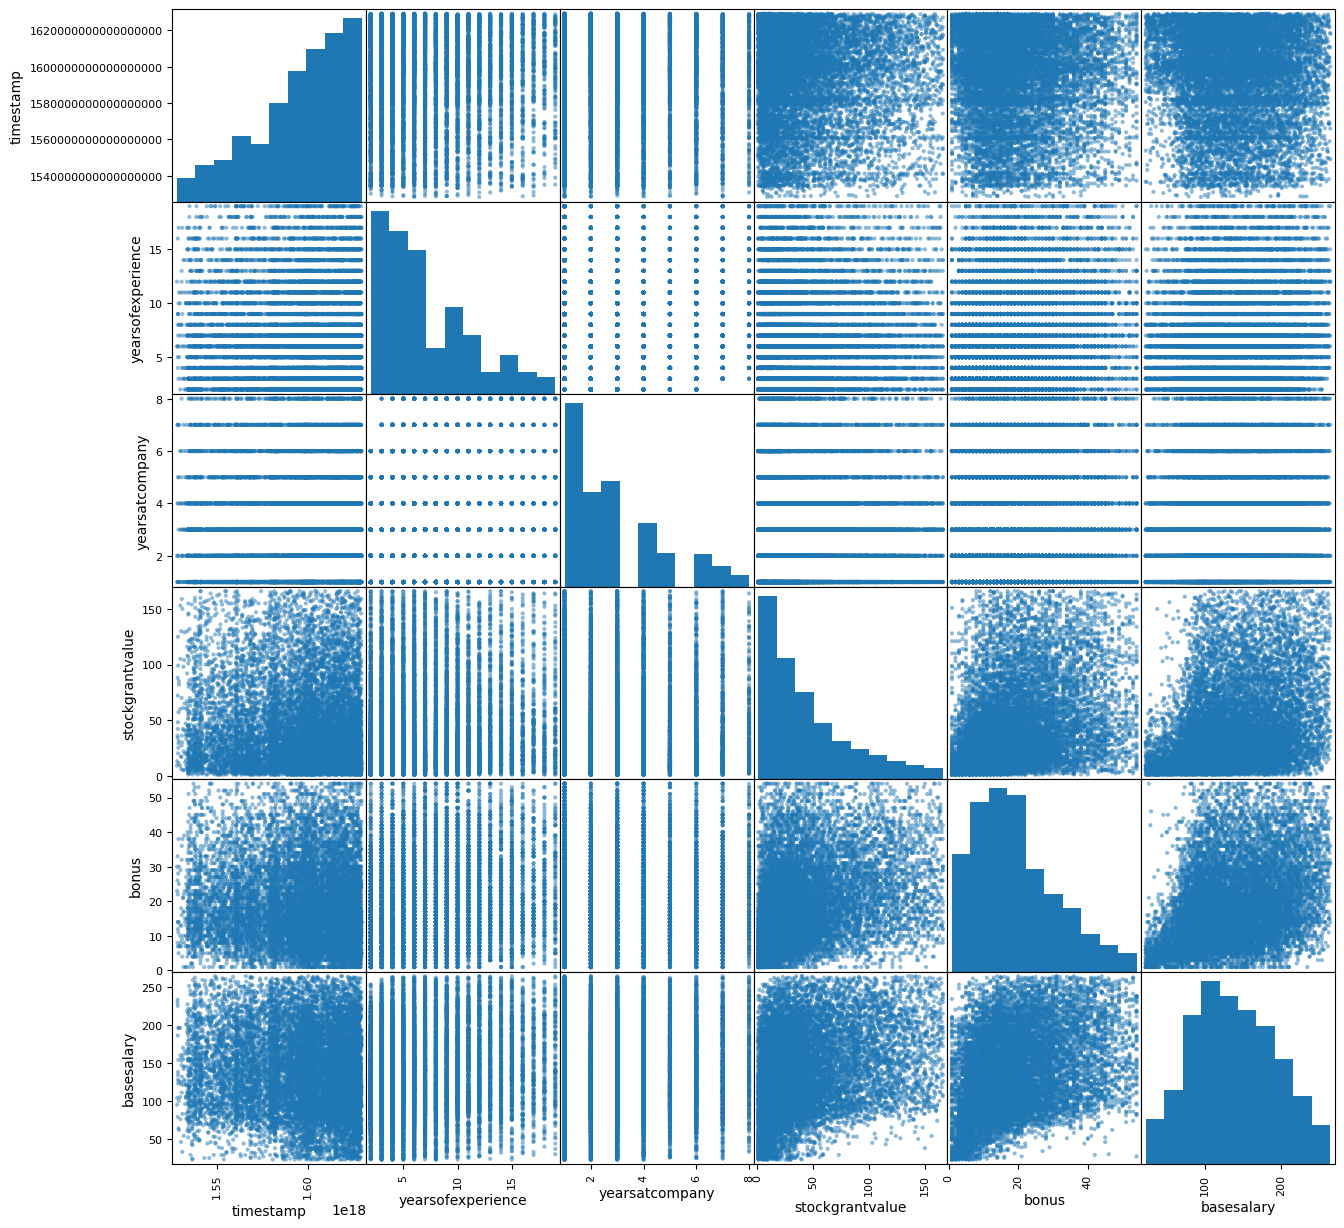

In [30]:
# plotting a scatter matrix allows us to visualize the correlations between each set of features in the dataset
m = scatter_matrix(copy_df, figsize=(15, 15))

It seems that the basesalary generally increases as the stockgrantvalue and bonus increases respectively. The basesalary also appear to increase as the features yearsofexperience and yearsatcompany increases, albeit very slightly. We can have a clearer view through drawing larger scatterplots.

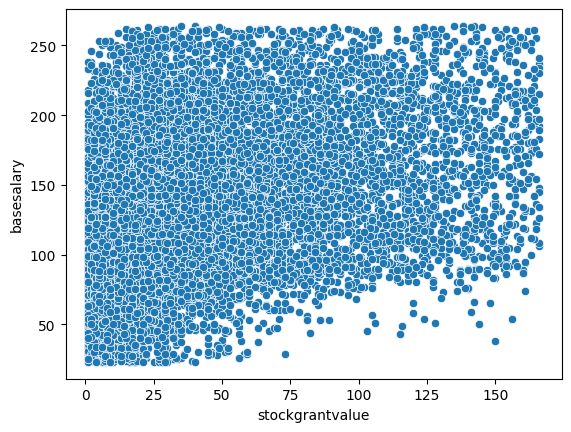

In [31]:
plot = scatterplot(x='stockgrantvalue', y='basesalary', data=copy_df)

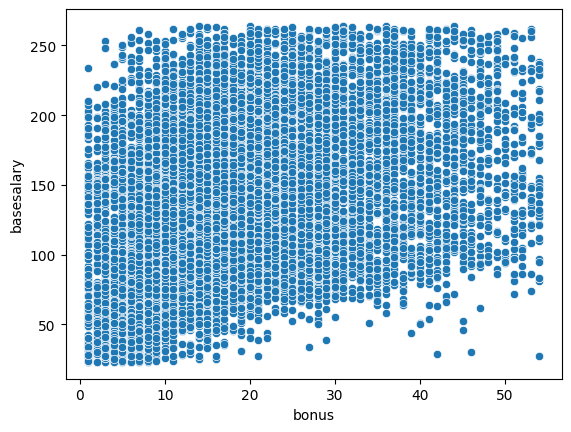

In [32]:
plot = scatterplot(x='bonus', y='basesalary', data=copy_df)

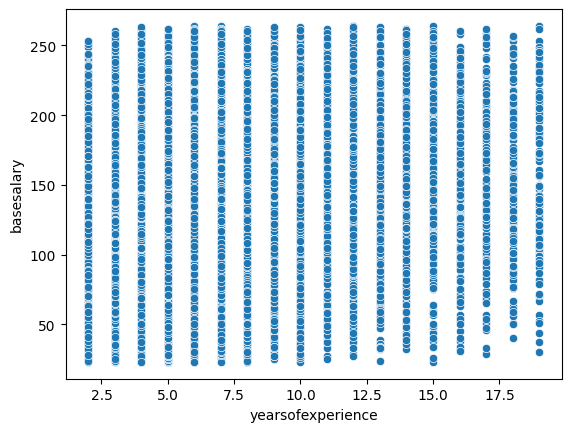

In [33]:
plot = scatterplot(x='yearsofexperience', y='basesalary', data=copy_df)

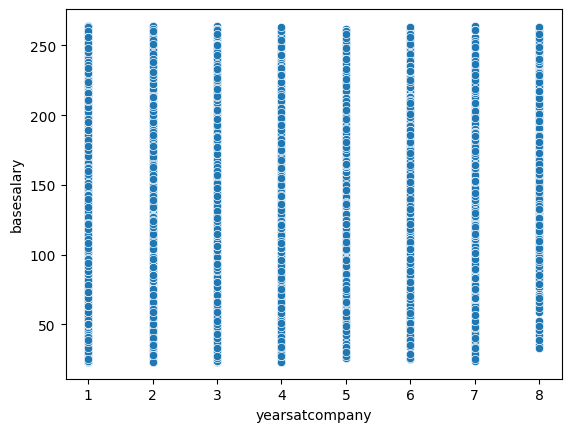

In [34]:
plot = scatterplot(x='yearsatcompany', y='basesalary', data=copy_df)

Indeed, there are 

<AxesSubplot: >

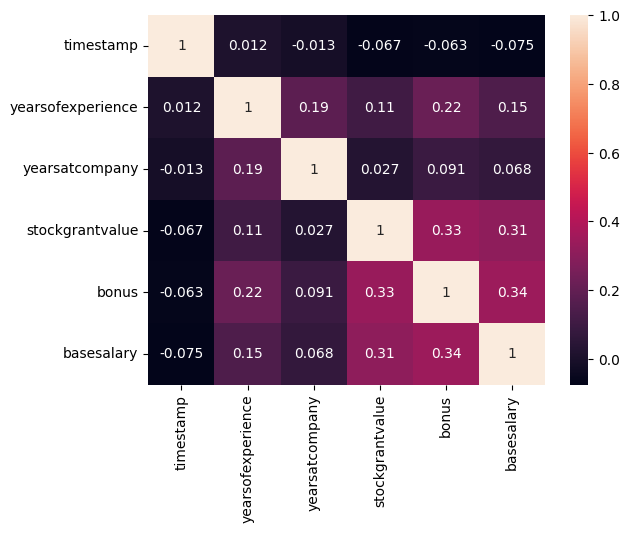

In [35]:
heatmap(copy_df.corr(numeric_only=True), annot=True)

The plot below shows that the salaries are relatively evenly distributed among the genders.

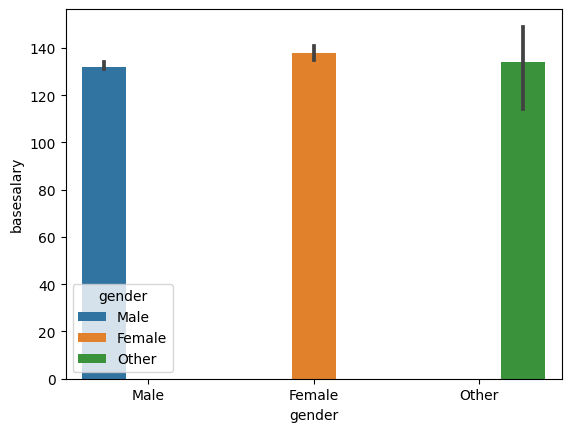

In [36]:
plot = barplot(x="gender", y="basesalary", hue="gender", data=copy_df, estimator="median")

The plots below illustrate that the bonus generally increases as years at company and years of experience increases.

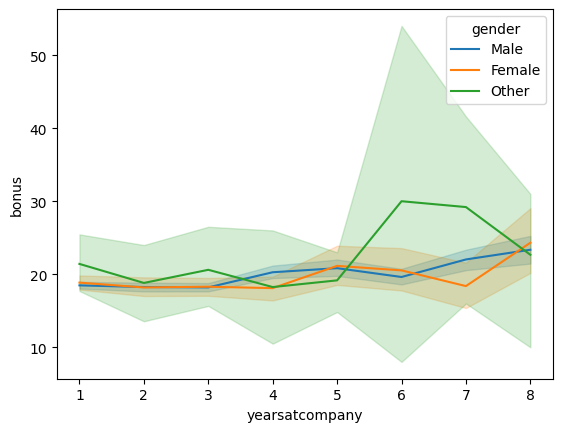

In [37]:
plot = lineplot(x="yearsatcompany", y="bonus", hue="gender", data=copy_df)

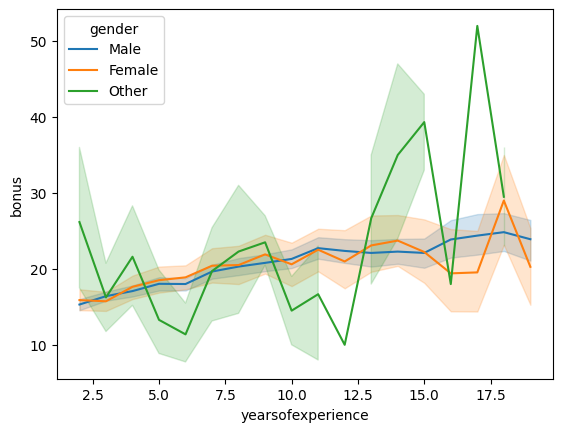

In [38]:
plot = lineplot(x="yearsofexperience", y="bonus", hue="gender", data=copy_df)

Additionally, the timestamp has a continuous range of values and it is not suitable to treat it directly as a categorical feature. We will can feature engineer months and quarters as categorial values to plot against basesalary.

In [39]:
copy_df['timestamp'] = pd.to_datetime(copy_df['timestamp'])

<h1>Feature Engineering Ideas</h1>

In [40]:
# Allows us to find out the relationship of basesalary with time 
copy_df["quarter_of_year"] = copy_df["timestamp"].dt.to_period("Q").astype('str')
copy_df["month_of_year"] = copy_df["timestamp"].dt.strftime("%Y%m")

# Combining level, company and title
copy_df["level_company_title"] = copy_df["level"] + copy_df["company"] + (copy_df["title"])

# Other numerical features
copy_df["bonus_per_years"] = copy_df["bonus"] + copy_df["stockgrantvalue"]/ (copy_df["yearsofexperience"] + copy_df["yearsatcompany"])
copy_df["bonus_per_stock"] = copy_df["bonus"] / copy_df["stockgrantvalue"]
copy_df["stock_per_exp"] = copy_df["stockgrantvalue"]/ copy_df["yearsofexperience"]

The graph below shows the fluctuation of the basesalary with time.

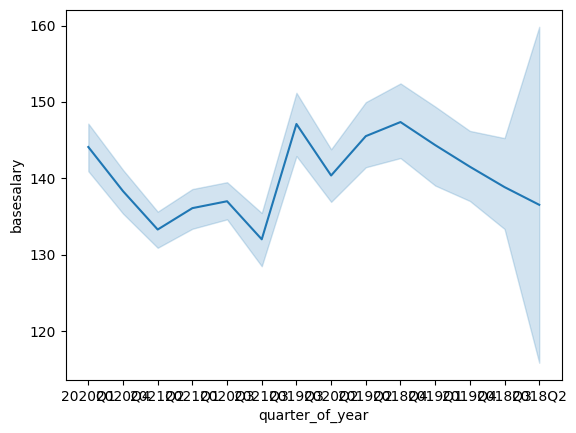

In [41]:
plot = lineplot(x="quarter_of_year", y="basesalary", data=copy_df)

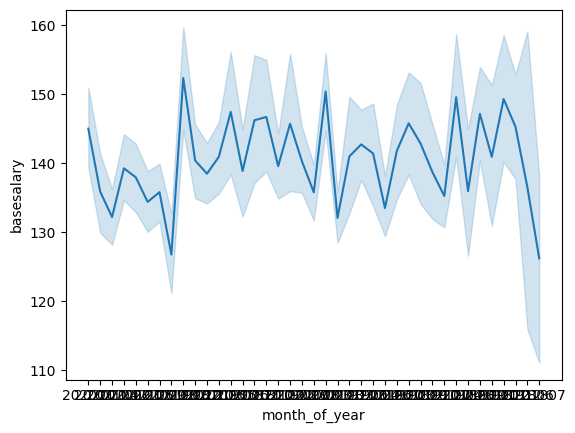

In [42]:
plot = lineplot(x="month_of_year", y="basesalary", data=copy_df)

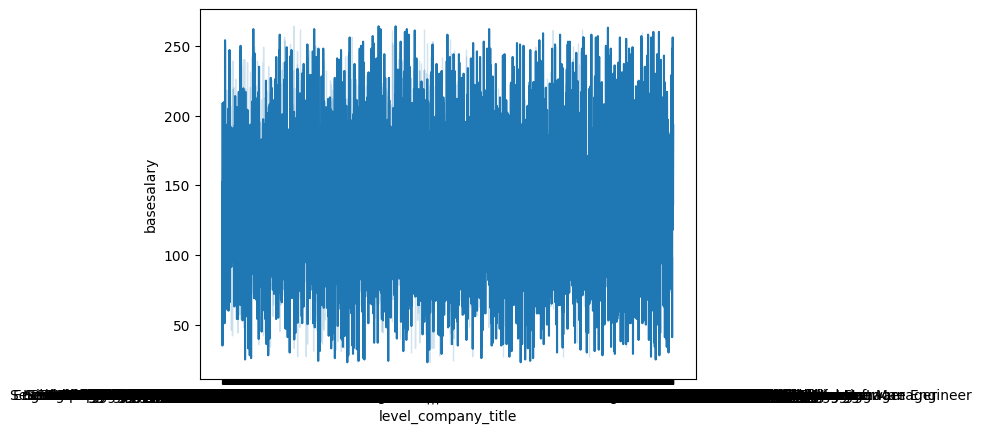

In [43]:
plot = lineplot(x="level_company_title", y="basesalary", data=copy_df)

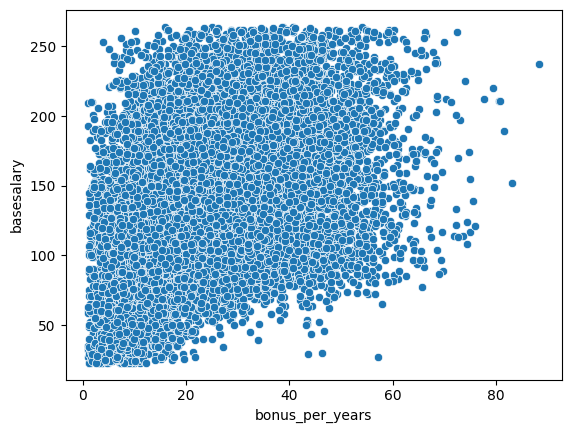

In [44]:
plot = scatterplot(x="bonus_per_years", y="basesalary", data=copy_df)

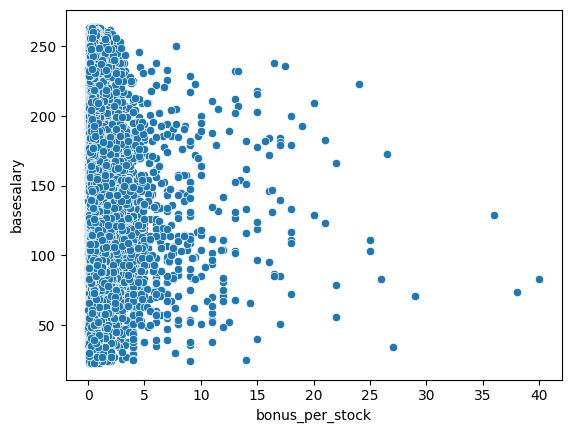

In [45]:
plot = scatterplot(x="bonus_per_stock", y="basesalary", data=copy_df)

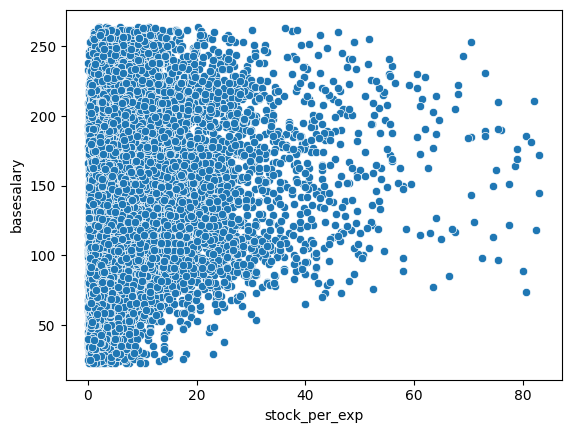

In [46]:
plot = scatterplot(x="stock_per_exp", y="basesalary", data=copy_df)

<AxesSubplot: >

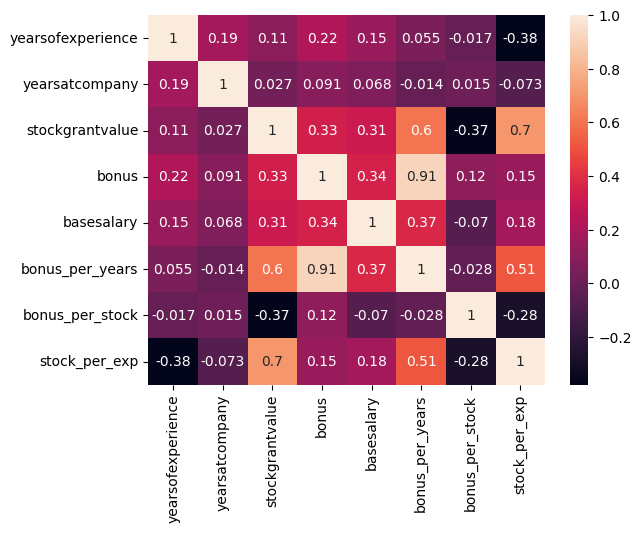

In [47]:
heatmap(copy_df.corr(numeric_only=True), annot=True)

In [63]:
class Insert_Quarter_of_Year(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            print(X.timestamp)
            X['timestamp'] = pd.to_datetime(X['timestamp'])
            X["quarter_of_year"] = X["timestamp"].dt.to_period("Q").astype('str')
            X = X.replace( [ np.inf, -np.inf ], np.nan )
        return X

In [64]:
class Insert_Month_of_Year(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X['timestamp'] = pd.to_datetime(X['timestamp'])
            X["month_of_year"] = X["timestamp"].datetime.strftime("%Y%m")
            X = X.replace( [ np.inf, -np.inf ], np.nan )
        return X

In [65]:
class Insertbonus_per_years(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X["bonus_per_years"] = X["bonus"] + X["stockgrantvalue"]/ (X["yearsofexperience"] + X["yearsatcompany"])
            X = X.replace( [ np.inf, -np.inf ], np.nan )
        return X

In [66]:
class Insertbonus_per_years(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X["bonus_per_years"] = X["bonus"] + X["stockgrantvalue"]/ (X["yearsofexperience"] + X["yearsatcompany"])
            X = X.replace( [ np.inf, -np.inf ], np.nan )
        return X

In [67]:
class Insertstock_per_exp(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X["stock_per_exp"] = X["stockgrantvalue"]/X["yearsofexperience"]
            X = X.replace( [ np.inf, -np.inf ], np.nan )
        return X

In [68]:
class Insertstock_per_years_company(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X["stock_per_exp"] = X["stockgrantvalue"]/X["yearsatcompany"]
            X = X.replace( [ np.inf, -np.inf ], np.nan )
        return X

<h1>Model Selection</h1>

In [69]:
# Split off the validation set: 20% of the entire dataset.
# Since the remaining training set is 60% of entire dataset, that is equal to 75% of the development dataset
# Create the object that shuffles and splits the dev data
ss = ShuffleSplit(n_splits=1, train_size=0.75, random_state=2)
ss

ShuffleSplit(n_splits=1, random_state=2, test_size=None, train_size=0.75)

In [70]:
preprocessor = ColumnTransformer(
        [("num", Pipeline([
                        ("bonus_per_years", Insertbonus_per_years()),
                        ("stock_per_years_company", Insertstock_per_years_company()),
                        ("stock_per_exp", Insertstock_per_exp()),
                        ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
                        ("scaler", StandardScaler())]), numeric_features),
        ("nom", Pipeline([
                        ("quarter_of_year", Insert_Quarter_of_Year()),
                        ("month_of_year", Insert_Month_of_Year()),
                        ("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                        ("binarizer", OneHotEncoder(handle_unknown="ignore"))]), nominal_features)],
        remainder="passthrough")

In [71]:
def build_model(model, additional_params={}):
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("predictor", model)])

    model_param_grid = {
        "preprocessor__num__bonus_per_years__insert": [True, False],
        "preprocessor__num__stock_per_years_company__insert": [True, False],
        "preprocessor__num__stock_per_exp__insert": [True, False],
        "preprocessor__nom__quarter_of_year__insert": [True, False],
        "preprocessor__nom__month_of_year__insert": [True, False],
    }
    
    model_param_grid.update(additional_params)

    model_gs = GridSearchCV(model, model_param_grid, scoring="neg_mean_absolute_error", cv=ss, refit=True)

    model_gs.fit(dev_X, dev_y)

    print("Best hyperparameters:", model_gs.best_params_, model_gs.best_score_)
    
    return model_gs

In [72]:
# Test whether the models are a good fit
def validate_training(model, model_type:str):
    scores = cross_validate(linear_gs, dev_X, dev_y, cv=ss, scoring="neg_mean_absolute_error", return_train_score=True)
    print(model_type, "Training error: ", np.mean(np.abs(scores["train_score"])))
    print(model_type, "Validation error: ", np.mean(np.abs(scores["test_score"])))

In [73]:
# Build a linear regression model, finding its hyperparameters via GridSearch.
linear_gs = build_model(LinearRegression())

/home/boderptart/CS4618/env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 32.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/home/boderptart/CS4618/env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/boderptart/CS4618/env/lib/python3.8/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/boderptart/CS4618/env/lib/python3.8/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_

Best hyperparameters: {'preprocessor__nom__month_of_year__insert': False, 'preprocessor__nom__quarter_of_year__insert': False, 'preprocessor__num__bonus_per_years__insert': True, 'preprocessor__num__stock_per_exp__insert': True, 'preprocessor__num__stock_per_years_company__insert': True} -38.8057633126003


In [74]:
# linear regressor model is overfitted, since training error is low while validation error is relatively high
validate_training(linear_gs, "Linear")

/home/boderptart/CS4618/env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 32.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/home/boderptart/CS4618/env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/boderptart/CS4618/env/lib/python3.8/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/boderptart/CS4618/env/lib/python3.8/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_

Linear Training error:  28.355698879931662
Linear Validation error:  38.818501785673845


In [ ]:
knn_gs = build_model(KNeighborsRegressor(), additional_params={"predictor__n_neighbors": [x for x in range(30, 40)]})

In [61]:
# k nearest neighbors regressor is also overfitted, since training error is low while validation error is relatively high
validate_training(knn_gs, "KNN")

/home/boderptart/CS4618/env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 32.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/home/boderptart/CS4618/env/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 3800, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/ha

KNN Training error:  28.355698879931662
KNN Validation error:  38.818501785673845


<h1>Moment of truth (Evaluating on the test set)</h1>

In [62]:
mean_absolute_error(test_y, knn_gs.predict)

TypeError: Expected sequence or array-like, got <class 'method'>

In [ ]:
# score = cross_val_score(knn_gs, X, y, scoring="neg_mean_absolute_error", cv=10)
# score

In [ ]:
# inputs = Input(shape=(len(features),))
# x = Normalization()